In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the dataset with labels

Random Validation Images:


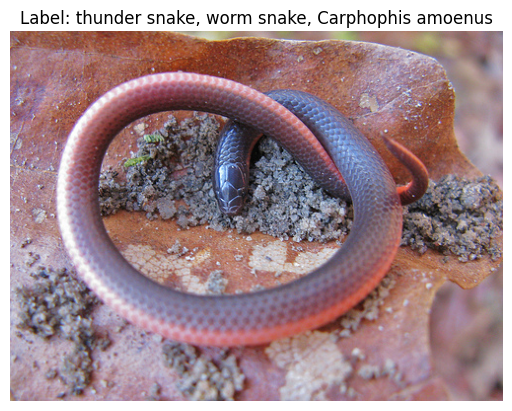

Random Training Images:


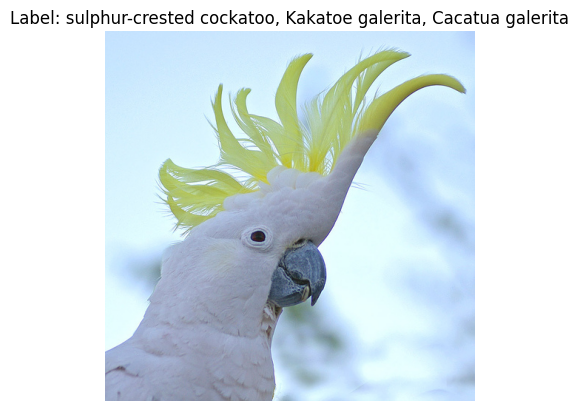

In [2]:
import json
import os
import random
import matplotlib.pyplot as plt
import cv2

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Create a mapping from class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}

# Function to display an image with its label
def show_image_with_label(image_path, label):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

# Directories containing the images
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# Helper function to get a random sample of images from a directory
def get_random_images(data_dirs, num_samples=5):
    images = []
    all_files = []
    for data_dir in data_dirs:
        for label_id in os.listdir(data_dir):
            class_name = id_to_class.get(label_id, 'Unknown')
            files = os.listdir(os.path.join(data_dir, label_id))
            all_files.extend([(os.path.join(data_dir, label_id, filename), class_name) for filename in files])

    selected_files = random.sample(all_files, num_samples)
    for image_path, class_name in selected_files:
        images.append((image_path, class_name))
    return images

# Get random images from validation set
val_images = get_random_images([val_dir], 1)

# Get random images from all training directories
train_images = get_random_images(train_dirs, 1)

# Display random validation images
print("Random Validation Images:")
for image_path, label in val_images:
    show_image_with_label(image_path, label)

# Display random training images
print("Random Training Images:")
for image_path, label in train_images:
    show_image_with_label(image_path, label)

# Setting up datasets and dataloadesr

In [ ]:
import os
import json
import random
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from cornet import cornet_s

In [3]:
!git clone https://github.com/dicarlolab/CORnet.git
# Navigate to the cloned repository folder
import os
os.chdir('/kaggle/working/CORnet')

# Install the package if needed
!pip install .

Cloning into 'CORnet'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 155 (delta 13), reused 9 (delta 8), pack-reused 135 (from 1)
Receiving objects: 100% (155/155), 68.11 KiB | 1.70 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Processing /kaggle/working/CORnet
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=613142fc95c447409625419d740f9c16a86ba06fc6f5609a9cda8eab7630852a
  Stored in directory: /tmp/pip-ephem-wheel-cache-mtxfsd_r/wheels/ab/bb/f9/8716bf8cc3f23c0cd07d33b31c64ed0bc87023663d6be90ad5
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=176b4f6458f7ba64a9cae80bb3a77ee91ccc5c701301658e0485c2e688096641
  Stored in directory: /root/.cache/pip/whe

In [6]:
import os
import json
import random
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from cornet import cornet_s

# Load labels from JSON file
with open('/kaggle/input/imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

# Mapping class ID to class name
id_to_class = {str(k): v for k, v in labels.items()}
class_to_idx = {cls_name: i for i, cls_name in enumerate(sorted(id_to_class.keys()))}

# Gaussian Blur Function
def apply_gaussian_blur(img, sigma):
    """Apply Gaussian blur with a given sigma value."""
    return cv2.GaussianBlur(img, (5, 5), sigmaX=sigma, sigmaY=sigma)

# Custom dataset with Blurry-to-Clear Training
class BlurryMultiFolderDataset(Dataset):
    def __init__(self, folders, transform=None, sigma=0):
        self.samples = []
        self.transform = transform
        self.sigma = sigma  # Blur level
        for folder in folders:
            for label_id in os.listdir(folder):
                class_name = id_to_class.get(label_id, 'Unknown')
                files = os.listdir(os.path.join(folder, label_id))
                self.samples.extend([(os.path.join(folder, label_id, filename), label_id) for filename in files])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Apply Gaussian Blur
        if self.sigma > 0:
            image = apply_gaussian_blur(image, self.sigma)

        image = Image.fromarray(image)  # Convert to PIL for transformations
        if self.transform:
            image = self.transform(image)

        label = class_to_idx[label]
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Directories
base_train_dir = '/kaggle/input/imagenet100'
val_dir = os.path.join(base_train_dir, 'val.X')
train_dirs = [os.path.join(base_train_dir, f'train.X{i}') for i in range(1, 5)]

# CORnet-S Model Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cornet_s(pretrained=False).to(device)

# Modify the classifier for ImageNet100
num_classes = 100
model.module.decoder.linear = nn.Linear(model.module.decoder.linear.in_features, num_classes).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Setup
num_epochs = 6
sigma_schedule = [8, 4, 2, 1, 0]  # Blur levels decreasing every 10 epochs
batch_size = 64

# Create checkpoint directory
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to save checkpoint
def save_checkpoint(epoch, model, optimizer, best=False):
    checkpoint_path = f"{checkpoint_dir}/checkpoint_epoch_{epoch}.pth"
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    if best:
        torch.save(model.state_dict(), f"{checkpoint_dir}/best_model.pth")
    print(f"Checkpoint saved at {checkpoint_path}")

# Training Loop with Blurry-to-Clear Training
best_val_acc = 0.0
for epoch in range(num_epochs):
    sigma = sigma_schedule[min(epoch // 10, len(sigma_schedule) - 1)]  # Adjust blur level

    # Load train dataset with current blur level
    train_dataset = BlurryMultiFolderDataset(train_dirs, transform=transform, sigma=sigma)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Load validation dataset (no blur)
    val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Training Phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Blur σ={sigma}")

    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_pbar.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total

    # Validation Phase
    model.eval()
    correct, total = 0, 0
    val_pbar = tqdm(val_loader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save checkpoint
    save_checkpoint(epoch + 1, model, optimizer)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(epoch + 1, model, optimizer, best=True)

Epoch 1/6, Blur σ=8: 100%|██████████| 2032/2032 [54:23<00:00,  1.61s/it, acc=13.5, loss=3.33]


Epoch 1/6 - Train Loss: 3.6472, Train Acc: 13.49%, Val Acc: 20.54%
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_1.pth
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_1.pth


Epoch 2/6, Blur σ=8: 100%|██████████| 2032/2032 [47:26<00:00,  1.40s/it, acc=29.8, loss=3.52]


Epoch 2/6 - Train Loss: 2.7828, Train Acc: 29.84%, Val Acc: 29.78%
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_2.pth
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_2.pth


Epoch 3/6, Blur σ=8: 100%|██████████| 2032/2032 [48:15<00:00,  1.42s/it, acc=39.3, loss=2.76]


Epoch 3/6 - Train Loss: 2.3408, Train Acc: 39.32%, Val Acc: 36.96%
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_3.pth
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_3.pth


Epoch 4/6, Blur σ=8: 100%|██████████| 2032/2032 [48:59<00:00,  1.45s/it, acc=46.3, loss=2.36]


Epoch 4/6 - Train Loss: 2.0374, Train Acc: 46.27%, Val Acc: 42.58%
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_4.pth
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_4.pth


Epoch 5/6, Blur σ=8: 100%|██████████| 2032/2032 [49:28<00:00,  1.46s/it, acc=51.7, loss=1.78]


Epoch 5/6 - Train Loss: 1.8072, Train Acc: 51.69%, Val Acc: 45.76%
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_5.pth
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_5.pth


Epoch 6/6, Blur σ=8: 100%|██████████| 2032/2032 [48:53<00:00,  1.44s/it, acc=55.9, loss=2.04] 


Epoch 6/6 - Train Loss: 1.6287, Train Acc: 55.94%, Val Acc: 42.24%
Checkpoint saved at /kaggle/working/checkpoints/checkpoint_epoch_6.pth


In [7]:
# Save the final trained model
model_save_path = "/kaggle/working/cornet_s_final.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Final model saved at {model_save_path}")

Final model saved at /kaggle/working/cornet_s_final.pth


In [8]:
# Load the saved model
model = cornet_s(pretrained=False).to(device)
model.module.decoder.linear = nn.Linear(model.module.decoder.linear.in_features, 100).to(device)
model.load_state_dict(torch.load("/kaggle/working/cornet_s_final.pth"))
model.eval()  # Set to evaluation mode
print("Model loaded successfully")

<ipython-input-8-9ec95ec34cc9>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/cornet_s_final.pth"))


Model loaded successfully


In [9]:
# Evaluate the model
correct1, correct5, total = 0, 0, 0
model.eval()

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating Model"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Top-1 and Top-5 Accuracy
        _, pred1 = outputs.topk(1, 1, True, True)
        _, pred5 = outputs.topk(5, 1, True, True)
        correct1 += pred1.eq(labels.view(-1, 1).expand_as(pred1)).sum().item()
        correct5 += pred5.eq(labels.view(-1, 1).expand_as(pred5)).sum().item()
        total += labels.size(0)

# Compute final accuracy
top1_acc = correct1 / total
top5_acc = correct5 / total

print(f"Final Model Accuracy:")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

Evaluating Model: 100%|██████████| 79/79 [00:50<00:00,  1.55it/s]

Final Model Accuracy:
Top-1 Accuracy: 0.4214
Top-5 Accuracy: 0.7176
